In [2]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
sz_ft = 20
sz_lb = 14
color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen', 'goldenrod', 'darkred']
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

In [4]:
nber_clus = 3000
nber_rand = 30000
nber_cov = 500
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
cluster_2e14 = [2e14, cosmo.concentration_parameter(2e14, 0.7, 0.674), 0.7]
cluster_6e14 = [6e14, cosmo.concentration_parameter(6e14, 0.7, 0.674), 0.7]
cluster_10e14 = [10e14, cosmo.concentration_parameter(10e14, 0.7, 0.674), 0.7]
cluster_arr = [cluster_2e14, cluster_6e14, cluster_10e14]
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.0)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.0)
cl_noise =  nl_deconvolved
nber_clus_fit = 30000
nber_rand_fit = 30000
mass_int_estimator_validation = np.arange(0, 5.9, 0.1)
z = 0.7

In [3]:
maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl, nber_obs = nber_rand)
stack_bg_estimator_validation = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
del maps_rand
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/stack_bg_estimator_validation.npy', stack_bg_estimator_validation)   

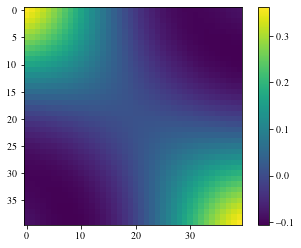

In [4]:
covariance_matrix_estimator_validation = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/covariance_matrix_estimator_validation.npy')  
plt.imshow(covariance_matrix_estimator_validation)
plt.colorbar()

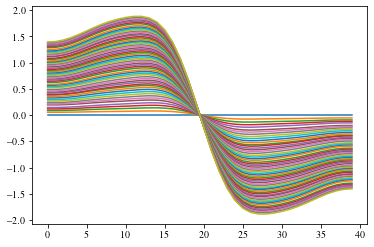

In [5]:
model_profiles_estimator_validation = []
model_profile_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/model_profiles/model_profiles_30000clusters_M200c0.000_z0.70.npy')
for mass in mass_int_estimator_validation:
    model_profile = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/model_profiles/model_profiles_30000clusters_M200c'+str(round(mass,1))+'00_z0.70.npy')
    model_profiles_estimator_validation.append(model_profile-model_profile_bg)
for i in range(len(mass_int_estimator_validation)):
    plt.plot(model_profiles_estimator_validation[i])

In [1]:
stack_bg_estimator_validation = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/stack_bg_estimator_validation.npy')   


lk_arr_2e14 = []      
lk_arr_6e14 = []  
lk_arr_10e14 = []  
for i in tqdm(range(25)):  
    maps_clus = sims.cmb_test_data(map_params, l, cl, cluster = cluster_arr, bl = bl, nl = nl, nber_obs = nber_clus, estimator_validation = True)
    maps_clus_2e14, maps_clus_6e14, maps_clus_10e14 = maps_clus[0], maps_clus[1], maps_clus[2]
    stack_clus_2e14 = lensing_estimator.stack(map_params, maps_clus_2e14, l = l, cl = cl, cl_noise = cl_noise)
    stack_clus_6e14 = lensing_estimator.stack(map_params, maps_clus_6e14, l = l, cl = cl, cl_noise = cl_noise)
    stack_clus_10e14 = lensing_estimator.stack(map_params, maps_clus_10e14, l = l, cl = cl, cl_noise = cl_noise)
    bins_2e14, lensing_dipole_profile_2e14, stack_dipole_2e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_2e14, stack_bg_estimator_validation)
    bins_6e14, lensing_dipole_profile_6e14, stack_dipole_6e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_6e14, stack_bg_estimator_validation)
    bins_10e14, lensing_dipole_profile_10e14, stack_dipole_10e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_10e14, stack_bg_estimator_validation)
    data_2e14 = bins_2e14, lensing_dipole_profile_2e14, covariance_matrix_estimator_validation
    data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix_estimator_validation
    data_10e14 = bins_10e14, lensing_dipole_profile_10e14, covariance_matrix_estimator_validation
   

    likelihood_2e14, _, _ = stats.run_ml(data_2e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_2e14, lk_2e14 = likelihood_2e14
    likelihood_6e14, _, _ = stats.run_ml(data_6e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_6e14, lk_6e14 = likelihood_6e14
    likelihood_10e14, _, _ = stats.run_ml(data_10e14, model_profiles_estimator_validation, mass_int_estimator_validation)
    mass_int_lk_10e14, lk_10e14 = likelihood_10e14
    lk_arr_2e14.append(lk_2e14)
    lk_arr_6e14.append(lk_6e14)
    lk_arr_10e14.append(lk_10e14)
    
    del maps_clus
    
del maps_clus
del maps_clus_2e14
del maps_clus_6e14
del maps_clus_10e14


lk_arr_estimator_validation = [lk_arr_2e14, lk_arr_6e14, lk_arr_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/lk_arr_estimator_validation_'+str(mass)+'e14.npy', lk_arr_estimator_validation[i]) 
    
comb_lk_2e14, mass_value_comb_lk_2e14, error_comb_lk_2e14 = stats.combined_likelihood(mass_int_lk_2e14, lk_arr_2e14)      
comb_lk_6e14, mass_value_comb_lk_6e14, error_comb_lk_6e14 = stats.combined_likelihood(mass_int_lk_6e14, lk_arr_6e14)      
comb_lk_10e14, mass_value_comb_lk_10e14, error_comb_lk_10e14 = stats.combined_likelihood(mass_int_lk_10e14, lk_arr_10e14)      
comb_lk_arr_estimator_validation = [comb_lk_2e14, comb_lk_6e14, comb_lk_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/comb_lk_arr_estimator_validation_'+str(mass)+'e14.npy', comb_lk_arr_estimator_validation[i]) 
mass_results_estimator_validation = "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_2e14, "+-", error_comb_lk_2e14) + "\n"
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_6e14, "+-", error_comb_lk_6e14) + "\n"          
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_10e14, "+-", error_comb_lk_10e14) + "\n"
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results_srini/mass_results_estimator_validation.txt',"w")
file.write(mass_results_estimator_validation)
file.close() 

NameError: name 'np' is not defined

In [ ]:
print(mass_value_comb_lk_2e14)
print(error_comb_lk_2e14)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
for i in range(30):
    ax1.plot(mass_int_lk_2e14[1000:3000], lk_arr_2e14[i][1000:3000], color = 'red', ls='-', alpha = 0.1)
ax1.plot(mass_int_lk_2e14[1000:3000], comb_lk_2e14[1000:3000], color = 'black', ls = '-', label = 'Combined')
ax1.tick_params(labelsize = sz_lb)
ax1.axvline(2, color = 'green', ls = '--', label = 'True') 
ax1.set_xlabel(r'$M_{200}\ [10^{14}M_\odot]$', fontsize = sz_ft)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = sz_ft)
ax1.legend(prop={'size': sz_lb}) 

In [174]:
model_profiles_estimator_validation1 = lensing_estimator.model_profiles(10000, 10000, map_params, l, cl, [0,2], z, bl = bl, cl_noise = cl_noise)

  0%|          | 0/10000 [00:00<?, ?it/s]/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:95: RuntimeWarning: invalid value encountered in double_scalars
  r_s = r_200/self.c_200
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:96: RuntimeWarning: invalid value encountered in double_scalars
  rho_s = (200 / 3) * rho_c * (self.c_200 ** 3 / (np.log(1 + self.c_200) - (self.c_200 / (1 + self.c_200))))
/Volumes/Extreme_SSD/codes/master_thesis/code/tools.py:58: RuntimeWarning: invalid value encountered in true_divide
  wiener_filter = psd_signal/(psd_signal+psd_noise)
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46:

In [175]:
model_profiles_estimator_validation2 = lensing_estimator.model_profiles(10000, 10000, map_params, l, cl, [0,2], z, bl = bl, cl_noise = cl_noise)

100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


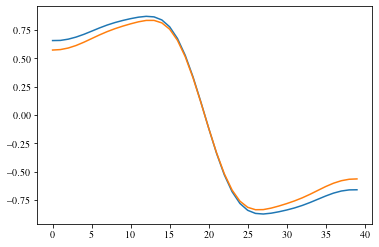

In [176]:
plt.plot(model_profiles_estimator_validation1[1])
plt.plot(model_profiles_estimator_validation2[1])

In [146]:
c200c = cosmo.concentration_parameter(2e14, 0.7, 0.674)
kappa_map = lensing.NFW(1e15, c200c, 0.7, 1100).convergence_map(map_params)
alpha_vec = lensing.deflection_from_convergence(map_params, kappa_map)

In [165]:
cl_noise = np.zeros(max(l)+1)
mapparams = [240, 0.25, 240, 0.25]
dx = 0.25

test_rand1 = []
for i in tqdm(range(100)):
    sim = sims.cmb_mock_data(map_params, l, cl)
    test_rand1.append(sim)
    
cutouts_rand1 = []
for i in tqdm(range(100)):
    cutout = tools.central_cutout(map_params, test_rand1[i], 10)
    wiener_filter = tools.wiener_filter(l, cl, cl_noise)
    low_pass_filter = tools.low_pass_filter(l, 2000)
    filtered_map = tools.convolve(test_rand1[i], l, wiener_filter * low_pass_filter, map_params) 
    filtered_cutout = tools.central_cutout(map_params, filtered_map, 6)
    _, _, magnitude, angle = tools.gradient(filtered_cutout, dx)
    angle, magnitude_weight = np.median(angle), np.median(magnitude) 
    cutout_aligned = tools.rotate(cutout, angle)
    cutout_aligned -= np.median(cutout_aligned)
    cutouts_rand1.append(cutout_aligned)
stack_bg1 = np.mean(cutouts_rand1, axis = 0)
    
    
test_clus1 = []
for i in tqdm(range(100)):
    sim_lensed = lensing.lens_map(map_params, test_rand1[i], alpha_vec)
    test_clus1.append(sim_lensed)    
    
    
cutouts_clus1 = []
for i in tqdm(range(100)):
    cutout = tools.central_cutout(map_params, test_clus1[i], 10)
    wiener_filter = tools.wiener_filter(l, cl, cl_noise)
    low_pass_filter = tools.low_pass_filter(l, 2000)
    filtered_map = tools.convolve(test_clus1[i], l, wiener_filter * low_pass_filter, map_params) 
    filtered_cutout = tools.central_cutout(map_params, filtered_map, 6)
    _, _, magnitude, angle = tools.gradient(filtered_cutout, dx)
    angle, magnitude_weight = np.median(angle), np.median(magnitude) 
    cutout_aligned = tools.rotate(cutout, angle)
    cutout_aligned -= np.median(cutout_aligned)
    cutouts_clus1.append(cutout_aligned)
stack_clus1 = np.mean(cutouts_clus1, axis = 0)

  0%|          | 0/100 [00:00<?, ?it/s]/Volumes/Extreme_SSD/codes/master_thesis/code/tools.py:58: RuntimeWarning: invalid value encountered in true_divide
  wiener_filter = psd_signal/(psd_signal+psd_noise)
100%|██████████| 100/100 [00:00<00:00, 261.99it/s]


In [166]:
cl_noise = np.zeros(max(l)+1)


test_rand2 = []
for i in tqdm(range(100)):
    sim =  sims.cmb_mock_data(map_params, l, cl) #tools.rotate(test_rand1[i], random.randint(-0,0))
    test_rand2.append(sim)

cutouts_rand2 = []
for i in tqdm(range(100)):
    cutout = tools.central_cutout(map_params, test_rand2[i], 10)
    wiener_filter = tools.wiener_filter(l, cl, cl_noise)
    low_pass_filter = tools.low_pass_filter(l, 2000)
    filtered_map = tools.convolve(test_rand2[i], l, wiener_filter * low_pass_filter, map_params) 
    filtered_cutout = tools.central_cutout(map_params, filtered_map, 6)
    _, _, magnitude, angle = tools.gradient(filtered_cutout, dx)
    angle, magnitude_weight = np.median(angle), np.median(magnitude) 
    cutout_aligned = tools.rotate(cutout, angle)
    cutout_aligned -= np.median(cutout_aligned)
    cutouts_rand2.append(cutout_aligned)
stack_bg2 = np.mean(cutouts_rand2, axis = 0)
    
    
test_clus2 = []
for i in tqdm(range(100)):
    sim_lensed = lensing.lens_map(map_params, test_rand2[i], alpha_vec)
    test_clus2.append(sim_lensed)    
    
    
cutouts_clus2 = []
for i in tqdm(range(100)):
    cutout = tools.central_cutout(map_params, test_clus2[i], 10)
    wiener_filter = tools.wiener_filter(l, cl, cl_noise)
    low_pass_filter = tools.low_pass_filter(l, 2000)
    filtered_map = tools.convolve(test_clus2[i], l, wiener_filter * low_pass_filter, map_params) 
    filtered_cutout = tools.central_cutout(map_params, filtered_map, 6)
    _, _, magnitude, angle = tools.gradient(filtered_cutout, dx)
    angle, magnitude_weight = np.median(angle), np.median(magnitude) 
    cutout_aligned = tools.rotate(cutout, angle)
    cutout_aligned -= np.median(cutout_aligned)
    cutouts_clus2.append(cutout_aligned)
stack_clus2 = np.mean(cutouts_clus2, axis = 0)

100%|██████████| 100/100 [00:00<00:00, 272.33it/s]


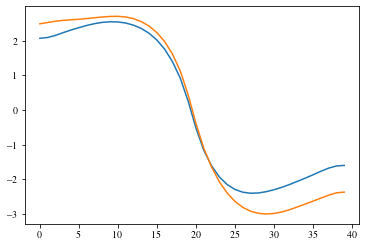

In [167]:
prf1 = np.mean(stack_clus1-stack_bg1, axis = 0)
prf2 = np.mean(stack_clus2-stack_bg2, axis = 0)
plt.plot(prf1)
plt.plot(prf2)

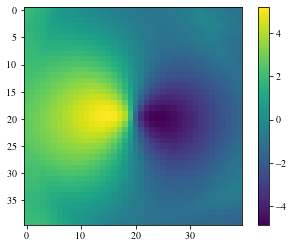

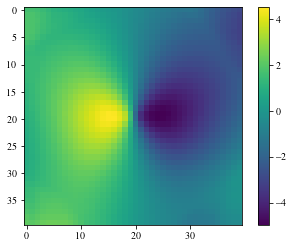

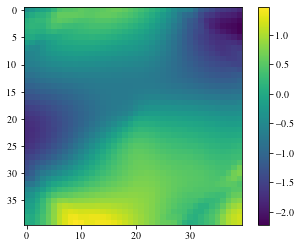

In [149]:
plt.imshow(stack_clus1-stack_bg1)
plt.colorbar()
plt.subplots()
plt.imshow(stack_clus2-stack_bg2)
plt.colorbar()
plt.subplots()
plt.imshow((stack_clus2-stack_bg2)-(stack_clus1-stack_bg1))
plt.colorbar()